In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import jax
from jax import grad
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from quad_utils import *
from other_utils import *


## Multivariate Single Gaussian

So we have:

$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$

$$
\boxed{v[k] = \sigma_f^2 |\mathbf{L}| |\Sigma_p + \mathbf{L^2}|^{-1/2} \exp\Big[-\frac{1}{2} (\mathbf{s}-\boldsymbol{\mu}_p)^T (\Sigma_p +  \mathbf{L^2})^{-1} (\mathbf{s}-\boldsymbol{\mu}_p) \Big]}
$$

$$
\boxed{vv[k] = \sigma_f^2 |\mathbf{L}| \, |2\Sigma_p + \mathbf{L^2}|^{-1/2}}
$$

where $$\textbf{k}_F(x) = \Big[ \int k(\boldsymbol{t}, x_1)p(\boldsymbol{t})d\boldsymbol{t},\, \int k(\boldsymbol{t}, x_2)p(\boldsymbol{t})d\boldsymbol{t},\, \cdots ,\, \int k(\boldsymbol{t}, x_n)p(\boldsymbol{t})d\boldsymbol{t} \Big]$$,
$$K(x'x) = \int \int k(\boldsymbol{t}, \boldsymbol{s})p(\boldsymbol{t})p(\boldsymbol{s})\,d\boldsymbol{s}\,d\boldsymbol{t} $$

and $K = k(X,X)$ is the Gram matrix of the training inputs under the kernel k.

In [2]:
def mc_nd(func, mus, covs, weights=None, n=100_000):
    mus = jnp.atleast_2d(mus)
    covs = np.array([np.diag(c) for c in covs])
    n_components, d = mus.shape

    # default to equal weights
    if weights is None:
        weights = np.ones(n_components)/n_components
    else:
        weights = np.array(weights)/np.sum(weights)

    counts = np.random.multinomial(n, weights)
    samples = np.empty((n, d))
    start = 0
    for i, n_i in enumerate(counts):
        if n_i > 0:
            samples[start:start+n_i] = np.random.multivariate_normal(mus[i], covs[i], n_i)
            start += n_i

    # evaluate function
    values = func(*samples.T)
    mean_est = np.mean(values)
    se_est = np.std(values, ddof=1)/np.sqrt(n)

    return mean_est, se_est

### Bivariate Single Gaussian

In [4]:
def common_components(
    x, y, s, L, 
    m0=None, x_m=None, w=None, 
    new_k=True):
    x = jnp.atleast_2d(x).astype(jnp.float64)
    if x.shape[0] == 1 and x.shape[1] > 1:
        x = x.T
    y = jnp.atleast_2d(y).reshape(-1, 1)
    n = x.shape[0]

    L = jnp.diag(L)

    if m0 is None:
        m0 = jnp.mean(y)
        x_m = jnp.mean(x, axis=0)
        w = (jnp.max(x, axis=0) - jnp.min(x, axis=0))/5.0
        w = 2

    x_m = jnp.asarray(x_m).reshape(-1)
    w = jnp.asarray(w).reshape(-1)
    m = m0 - 0.5*jnp.sum(((x - x_m)/w) ** 2, axis=1, keepdims=True)
    

    if new_k:

        Kxx = rbf(x, x, s, L) + 1e-10 * jnp.eye(n)
        chol_k = jnp.linalg.cholesky(Kxx)
        return x,y,L,m0,x_m,w,m,chol_k
    else:
        return x,y,L,m0,x_m,w,m
    


def gp_predict(
        xs, ys, x_eval, 
        s,L,m0,x_m,w, m,
        chol_k=None, K_inv=None, old_K=False
        ):
    x_eval = x_eval.reshape(-1, x_m.shape[0])
    M = m0 - 0.5*jnp.sum(((x_eval - x_m)**2)/(w**2), axis=1)



    K_s = rbf(xs, x_eval, s, L)
    K_ss = rbf(x_eval, x_eval, s, L)

    #rank one update is old_k
    if old_K:
        n_old = K_inv.shape[0]
        K12 = rbf(xs[:n_old], xs[n_old:], s, L)
        K21 = K12.T
        K22 = rbf(xs[n_old:], xs[n_old:], s, L)

        # Schur complement
        S = K22 - K21 @ K_inv @ K12
        chol_S = jnp.linalg.cholesky(S + 1e-10 * jnp.eye(S.shape[0]))

        def solve_S(b):
            return jax.scipy.linalg.cho_solve((chol_S, True), b)

        # Updated inverse blocks
        top_left = K_inv + K_inv @ K12 @ solve_S(K21 @ K_inv)
        top_right = -K_inv @ K12 @ solve_S(jnp.eye(K22.shape[0]))
        bottom_left = -solve_S(K21 @ K_inv)
        bottom_right = solve_S(jnp.eye(K22.shape[0]))

        # Assemble updated inverse
        K_inv = jnp.block([
            [top_left, top_right],
            [bottom_left, bottom_right]
        ])
    else:
        #normal update if 
        K_inv = jax.scipy.linalg.cho_solve((chol_k, True), jnp.eye(chol_k.shape[0]))

    # Compute mean and covariance
    ym = ys - m

    mu = M + (K_s.T @ K_inv @ ym).ravel()
    sig = K_ss - K_s.T @ K_inv @ K_s + 1e-9 * jnp.eye(K_ss.shape[0])

    return mu.ravel(), sig, K_inv


Ripple function
Bivariate normal with mean: [0, 0] and cov: [[1, 1]]

MC estimate: 0.25298816755768466
MC stdev: 0.0006993072774900226

Optimised params:
Optimal s:  2.6315426709190404
Optimal L:  [3.94568368 3.94568368]

GP estimate: 0.30855362139514664
GP stdev: 2.774338513073213e-06


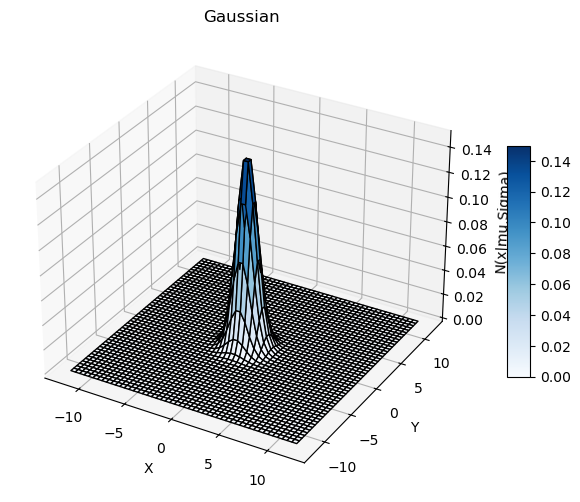

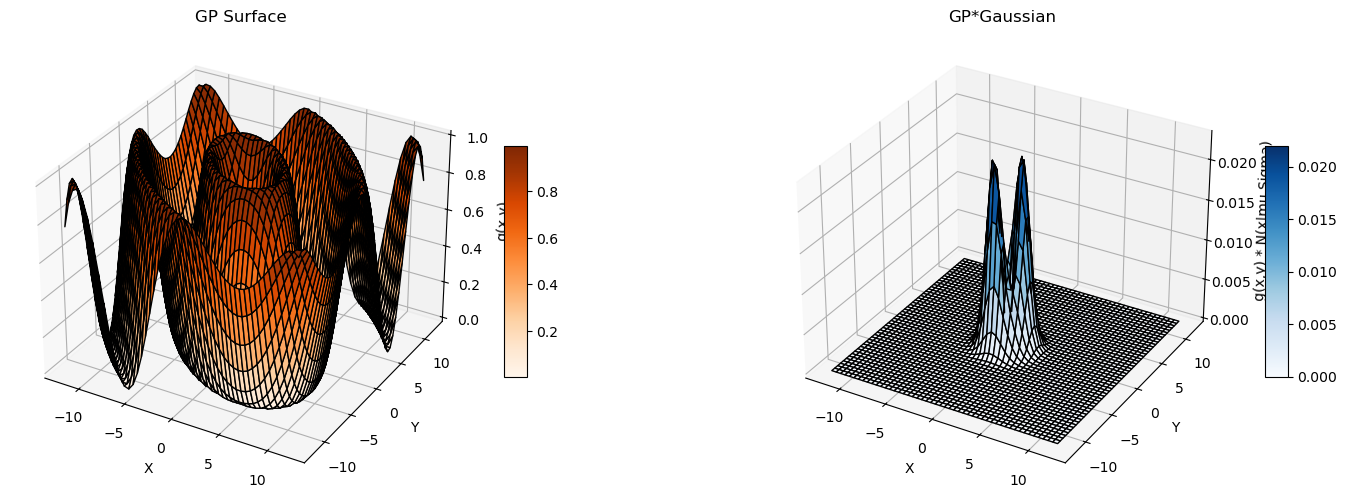

In [14]:
# Example function g(x,y)
def g(x, y):
    r = 0.4*np.sqrt(x**2 + x*y + y**2)
    return np.sin(r)**2


mean = [0, 0]
cov = [[1, 1]]

ev = mc_nd(g, mean, cov, n=100_000)
print('Ripple function')
print(f"Bivariate normal with mean: {mean} and cov: {cov}")
print()

print("MC estimate:", ev[0])
print("MC stdev:", ev[1])
print()


#training data
x = np.linspace(-11, 11, 29)
y = np.linspace(-11, 11, 29)
X, Y = np.meshgrid(x, y)
xy = jnp.column_stack([X.ravel(), Y.ravel()])
gxy1 = g(xy[:, 0], xy[:, 1])


mu_p = jnp.array(mean)
S_p = jnp.array(cov)


grad_fn = grad(neg_gp_likelihood)

s_init = 1
L_init = jnp.array([1,1])
init_params = jnp.concatenate([jnp.array([s_init]), L_init])

res = minimize(
    fun=lambda p: float(neg_gp_likelihood(p, xy, gxy1, rbf)),
    x0=init_params,
    jac=lambda p: jnp.array(grad_fn(p, xy, gxy1, rbf)),
    method="L-BFGS-B",
    bounds=[(1, 20)]*len(init_params)
)

#kernel hyperparameters
s = res.x[0]
L = res.x[1:]


print("Optimised params:")
print("Optimal s: ",s)
print("Optimal L: ",L)
print()

#compute integral
mu_int, var_int = integrate_gaussian_n(xy, gxy1, s, L, mu_p, S_p)
print("GP estimate:", mu_int)
print("GP stdev:", jnp.sqrt(var_int))


#evaluation points
x = np.linspace(-12, 12, 50)
y = np.linspace(-12, 12, 50)
X_eval, Y_eval = np.meshgrid(x, y)
xy_eval = np.column_stack([X_eval.ravel(), Y_eval.ravel()])

x1,y1,L1,m01,x_m1,w1,m1,chol_k1 = common_components(
        xy, gxy1, s=s, L=L, 
        m0=None, x_m=None, w=None, 
        new_k=True
        )
    
mu_grid, var_eval, K_inv = gp_predict(
        x1, y1, xy_eval,
        s=s,L=L1,
        m0=m01,x_m=x_m1,w=w1,m=m1,
        chol_k=chol_k1, K_inv=None, old_K=False)
mu_grid = mu_grid.reshape(X_eval.shape)


# Compute Gaussian pdf at evaluation points
Sigma = jnp.diag(S_p[0])
pdf_vals = comp_pdf(xy_eval, mu_p, Sigma)
pdf_grid = pdf_vals.reshape(X_eval.shape)

# Compute product of GP mean and Gaussian pdf
product_grid = mu_grid*pdf_grid


fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_eval, Y_eval, pdf_grid, cmap="Blues", edgecolor='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('N(x|mu,Sigma)')
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set_title('Gaussian')
plt.show()


# Plot GP surface and product surface side by side
fig = plt.figure(figsize=(18, 6))

# GP surface
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(X_eval, Y_eval, mu_grid, cmap="Oranges", edgecolor='k')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('g(x,y)')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
ax1.set_title('GP Surface')

# Product surface
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(X_eval, Y_eval, product_grid, cmap="Blues", edgecolor='k')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('g(x,y) * N(x|mu,Sigma)')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
ax2.set_title('GP*Gaussian')

plt.show()

### Trivariate Single Gaussian

In [10]:
def g3(x, y, z):
    r = 0.3*np.sqrt(x**2 + x*y + x*z + y*z + y**2 + z**2)
    return np.sin(3*r)**2


mean = [1, -1, 1]
cov = [[2, 1, 2]]

ev = mc_nd(g3, mean, cov, n=2_000_000)

print('Ripple function')
print(f"Trivariate normal with mean: {mean} and cov: {cov}")
print()
print("MC estimate:", ev[0])
print("MC stdev:", ev[1])
print()



#training data
x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)
z = np.linspace(-5, 5, 10)
X, Y, Z = np.meshgrid(x, y, z)
xyz = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])
gxyz = g3(*xyz.T)


mu_p = jnp.array(mean)
S_p = jnp.array(cov)

grad_fn = grad(neg_gp_likelihood)

s_init = 1
L_init = jnp.array([1,1,1])
m0_init = jnp.max(gxyz)
x_m_init = xyz[jnp.argmax(gxyz)]
W_init = jnp.var(xyz, axis=0) + 1e-6

init_params = jnp.concatenate([
    jnp.array([s_init]),
    L_init,
    jnp.array([m0_init]),
    x_m_init,
    W_init
])

res = minimize(
    fun=lambda p: float(neg_gp_likelihood(p, xyz, gxyz, rbf)),
    x0=init_params,
    jac=lambda p: jnp.array(grad_fn(p, xyz, gxyz, rbf)),
    method="L-BFGS-B",
    bounds=[(1, 20)]*len(init_params)
)

d = xyz.shape[1]
#kernel hyperparameters
s = res.x[0]
L = res.x[1:1+d]
m0 = res.x[1+d]
x_m = res.x[2+d:2+2*d]
W = res.x[2+2*d:2+3*d]

print("Optimised params:")
print("Optimal s: ",s)
print("Optimal L: ",L)
print()
print("Optimal m0: ",m0)
print("Optimal x_m: ",x_m)
print("Optimal W: ",W)
print()


mu_int, var_int = integrate_gaussian_n(xyz, gxyz, s, L, mu_p, S_p)
print("GP estimate:", mu_int)
print("GP stdev:", jnp.sqrt(var_int))

Ripple function
Trivariate normal with mean: [1, -1, 1] and cov: [[2, 1, 2]]

MC estimate: 0.6077436039565766
MC stdev: 0.0002395093246537175

Optimised params:
Optimal s:  1.0
Optimal L:  [1.39596403 1.39596629 1.39596627]

Optimal m0:  1.7040537112783105
Optimal x_m:  [1. 1. 1.]
Optimal W:  [20. 20. 20.]

GP estimate: 0.6205815930678489
GP stdev: 0.003443201420733143


## Multivariate Mixture

### Bivariate mixture

In [26]:
def common_components(x, y, s, L, m0=None, x_m=None, w=None):

    x = jnp.atleast_2d(x).astype(jnp.float64)
    y = jnp.atleast_2d(y).reshape(-1, 1)
    n = x.shape[0]

    L = jnp.diag(L)

    Kxx = rbf(x, x, s, L) + 1e-10 * jnp.eye(n)
    chol_k = jnp.linalg.cholesky(Kxx)

    if m0 is None:
        m0 = jnp.mean(y)
        x_m = jnp.mean(x, axis=0)
        w = (jnp.max(x, axis=0) - jnp.min(x, axis=0)) /25.0

    x_m = jnp.asarray(x_m).reshape(-1)
    w = jnp.asarray(w).reshape(-1)
    m = m0 - 0.5*jnp.sum(((x - x_m) / w) ** 2, axis=1, keepdims=True)
    
    return x,y,L,m0,x_m,w,m,chol_k


##accept new x,y points and take in old kxx inverse.
def integrate_mixture_n(x,y,params,
                        s,L,m0,x_m,w, 
                        m,chol_k, weights=None):
    mu_params = jnp.array(params[0])
    S_params  = jnp.array([jnp.diag(S) for S in params[1]])

    n_components, _ = mu_params.shape

    if weights is None:
        weights = jnp.ones(n_components) / n_components
    else:
        weights = jnp.array(weights) / jnp.sum(weights)

    # cross-covariances
    def comp_vals(mu_j, S_j):
        return jax.vmap(lambda xi: vk2(xi, s, L, mu_j, S_j))(x).reshape(-1)
    
    kFs = jnp.stack([comp_vals(mu_params[j], S_params[j])
                     for j in range(n_components)], axis=1)
    kF = (weights[None, :]*kFs).sum(axis=1).reshape(-1, 1)

    M_components = jnp.array([
        m0 - 0.5*(jnp.sum(((mu_params[j] - x_m)/w) ** 2) + jnp.sum(S_params[j] / (w**2)))
        for j in range(n_components)
    ])
    M = jnp.sum(weights*M_components)

    alpha = jax.scipy.linalg.cho_solve((chol_k, True), y - m)
    beta = jax.scipy.linalg.cho_solve((chol_k, True), kF)
    mu = M + kF.T @ alpha
    mu = mu.squeeze()

    #variance term
    vv_mix = 0
    for i in range(n_components):
        for j in range(n_components):
            vv_mix += weights[i]*weights[j]*Iij_n(i,j,s,L, params)

    #variance adjustment term
    adjustment = (kF.T @ beta).squeeze()

    var = vv_mix - adjustment
    
    return mu, var


Ripple function
Bivariate normal with mean: [[2, 3], [-3, -2], [-1.0, 1.0]] and cov: [[1.0, 3.0], [1.0, 3.0], [1.0, 1.0]]

MC estimate: 0.6073144622338754
MC stdev: 0.0004545308644676504
Optimised params:
Optimal s:  1.30929787861235
Optimal L:  [3.36998466 3.36998466]

Optimal m0:  2.0567852389590144
Optimal x_m:  [1. 1.]
Optimal W:  [20. 20.]

GP estimate: 0.6077840961544818
GP stdev: 0.0008121203035496458


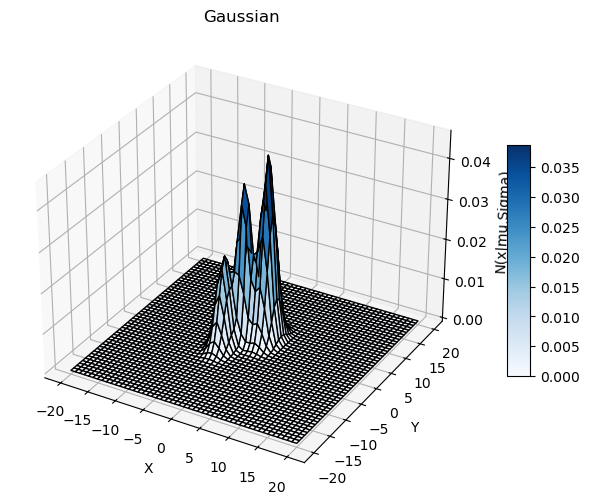

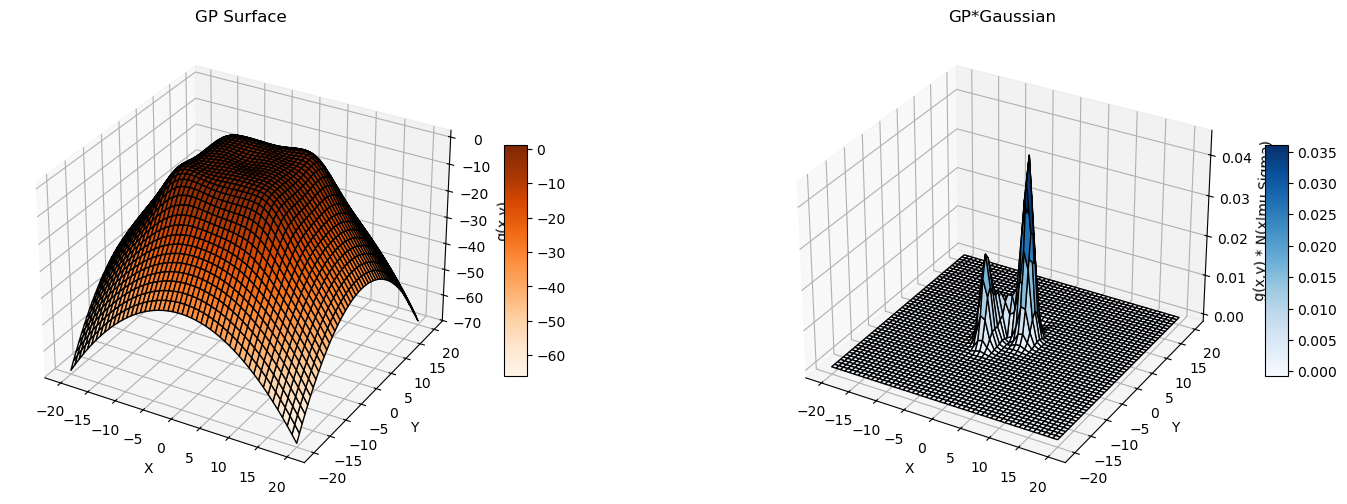

In [28]:
# Example function
def g(x, y):
    r = 0.4*np.sqrt(x**2 + x*y + y**2)
    return np.sin(r)**2

mean = [[2, 3], [-3, -2], [-1.0, 1.0]]
cov = [[1.0, 3.0], [1.0 ,3.0], [1.0, 1.0]]
weights = jnp.array([0.4, 0.2, 0.2])

ev = mc_nd(g, mean, cov, n=500_000, weights= weights)
print('Ripple function')
print(f"Bivariate normal with mean: {mean} and cov: {cov}\n")
print("MC estimate:", ev[0])
print("MC stdev:", ev[1])


#training data
x = np.linspace(-6, 6, 8)
y = np.linspace(-6, 6, 8)
X, Y = np.meshgrid(x, y)
xy = jnp.column_stack([X.ravel(), Y.ravel()])
gxy1 = g(xy[:, 0], xy[:, 1])


mu_p = jnp.array(mean)
S_p = jnp.array(cov)
params = mu_p, S_p

grad_fn = grad(neg_gp_likelihood)

s_init = 1
L_init = jnp.array([1,1])
m0_init = jnp.max(gxy1)
x_m_init = xy[jnp.argmax(gxy1)]
W_init = jnp.var(xy, axis=0) + 1e-6

init_params = jnp.concatenate([
    jnp.array([s_init]),
    L_init,
    jnp.array([m0_init]),
    x_m_init,
    W_init
])

res = minimize(
    fun=lambda p: float(neg_gp_likelihood(p, xy, gxy1, rbf)),
    x0=init_params,
    jac=lambda p: jnp.array(grad_fn(p, xy, gxy1, rbf)),
    method="L-BFGS-B",
    bounds=[(1, 20)]*len(init_params)
)

d = xy.shape[1]
#kernel hyperparameters
s = res.x[0]
L = res.x[1:1+d]
m0 = res.x[1+d]
x_m = res.x[2+d:2+2*d]
W = res.x[2+2*d:2+3*d]

print("Optimised params:")
print("Optimal s: ",s)
print("Optimal L: ",L)
print()
print("Optimal m0: ",m0)
print("Optimal x_m: ",x_m)
print("Optimal W: ",W)
print()

#compute integral
x_int,y_int, \
L_int,m0_int,x_m_int,w_int, \
m_int,chol_k_int = common_components(xy, gxy1, s, L, m0=m0, x_m=x_m, w=W)

mu_int, var_int = integrate_mixture_n(x_int, y_int, params,
                                         s, L_int, m0_int, x_m_int, w_int,
                                         m_int, chol_k_int, weights)
print("GP estimate:", mu_int)
print("GP stdev:", jnp.sqrt(var_int))


#evaluation points
x = np.linspace(-20, 20, 50)
y = np.linspace(-20, 20, 50)
X_eval, Y_eval = np.meshgrid(x, y)
xy_eval = np.column_stack([X_eval.ravel(), Y_eval.ravel()])
mu_grid, var_grid, _ = gp_predict(xy, gxy1, xy_eval, kernel=rbf, s=s, L=L)
mu_grid = mu_grid.reshape(X_eval.shape)


# Compute Gaussian pdf at evaluation points
Sigma = jnp.array([jnp.diag(s) for s in S_p])
pdf_vals = mixture_pdf(xy_eval, mu_p, Sigma, weights = weights)
pdf_grid = pdf_vals.reshape(X_eval.shape)

# Compute product of GP mean and Gaussian pdf
product_grid = mu_grid*pdf_grid


fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_eval, Y_eval, pdf_grid, cmap="Blues", edgecolor='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('N(x|mu,Sigma)')
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set_title('Gaussian')
plt.show()


# Plot GP surface and product surface side by side
fig = plt.figure(figsize=(18, 6))

# GP surface
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(X_eval, Y_eval, mu_grid, cmap="Oranges", edgecolor='k')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('g(x,y)')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
ax1.set_title('GP Surface')

# Product surface
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(X_eval, Y_eval, product_grid, cmap="Blues", edgecolor='k')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('g(x,y) * N(x|mu,Sigma)')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
ax2.set_title('GP*Gaussian')

plt.show()

### Trivariate Mixture

In [21]:
def g3(x, y, z):
    r = 0.3*np.sqrt(x**2 + x*y + x*z + y*z + y**2 + z**2)
    return np.sin(3*r)**2


mean = [[1, -2, 1], [-1, 0.4, 1]]
cov = [[1.0, 0.8, 2.0], [0.1, 2.0 ,2.0]]

ev = mc_nd(g3, mean, cov, n=500_000)

print('Ripple function')
print(f"Trivariate normal with mean: {mean} and cov: {cov}")
print()
print("MC estimate:", ev[0])
print("MC stdev:", ev[1])
print()

Ripple function
Trivariate normal with mean: [[1, -2, 1], [-1, 0.4, 1]] and cov: [[1.0, 0.8, 2.0], [0.1, 2.0, 2.0]]

MC estimate: 0.6345815951597074
MC stdev: 0.0004656552337079225



In [ ]:
#training data
x = np.linspace(-5, 5, 11)
y = np.linspace(-5, 5, 11)
z = np.linspace(-5, 5, 11)
X, Y, Z = np.meshgrid(x, y, z)
xyz = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])
gxyz = g3(*xyz.T)

mean = [[1, -2, 1], [-1, 0.4, 1]]
cov = [[1.0, 0.8, 2.0], [0.1, 2.0 ,2.0]]

mu_p = jnp.array(mean)
S_p = jnp.array(cov)
params = (mu_p, S_p)


grad_fn = grad(neg_gp_likelihood)

s_init = 1
L_init = jnp.array([2,2,2])
m0_init = jnp.max(gxyz)
x_m_init = xyz[jnp.argmax(gxyz)]
W_init = jnp.var(xyz, axis=0) + 1e-6

init_params = jnp.concatenate([
    jnp.array([s_init]),
    L_init,
    jnp.array([m0_init]),
    x_m_init,
    W_init
])


res = minimize(
    fun=lambda p: float(neg_gp_likelihood(p, xyz, gxyz, rbf)),
    x0=init_params,
    jac=lambda p: jnp.array(grad_fn(p, xyz, gxyz, rbf)),
    method="L-BFGS-B",
    bounds=[(1, 20)]*len(init_params)
)

d = xyz.shape[1]
#kernel hyperparameters
s = res.x[0]
L = res.x[1:1+d]
m0 = res.x[1+d]
x_m = res.x[2+d:2+2*d]
W = res.x[2+2*d:2+3*d]

print("Optimised params:")
print("Optimal s: ",s)
print("Optimal L: ",L)
print()
print("Optimal m0: ",m0)
print("Optimal x_m: ",x_m)
print("Optimal W: ",W)
print()


mu_int, var_int, _ = integrate_mixture_n(xyz, gxyz, s, L, params)
print("GP estimate:", mu_int)
print("GP stdev:", jnp.sqrt(var_int))


Optimised params:
Optimal s:  1.4693725322047722
Optimal L:  [1.5228683  1.52286827 1.52286827]

Optimal m0:  1.8161231180595556
Optimal x_m:  [1. 1. 1.]
Optimal W:  [20. 20. 20.]



ValueError: too many values to unpack (expected 2)